#1 Layer Network

Here we will make a network that will recognize 8x8 images of numbers. This will involve a creating a function that genrates networks and a function that can train the network.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.html.widgets import interact
from sklearn.datasets import load_digits
from IPython.display import Image, display
digits = load_digits()
print(digits.data.shape)

(1797, 64)


4

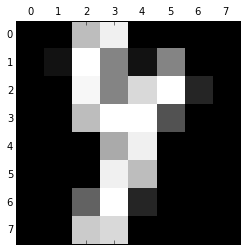

In [32]:
def show_examples(i):
    plt.matshow(digits.images[i].reshape((8,8)), cmap='Greys_r')
    display(digits.target[i])
interact(show_examples, i=[1,1797-1])

Our network will be comprised of a list of numpy arrays with each array containing the weights and bias for that layer of perceptions.

In [33]:
Image(url="http://neuralnetworksanddeeplearning.com/images/tikz35.png")

Credit to [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielsen for the image.

In [40]:
def gen_network(size):
    weights= [np.array([[np.random.randn() for _ in range(size[n-1]+1)]
               for _ in range(size[n])]) for n in range(len(size))[1:]]
    return weights
a = gen_network([2,2,1,3])

a

[array([[ 1.39743396,  0.85152653,  0.50398052],
        [ 0.63107563,  0.04117244,  1.09626974]]),
 array([[-0.82037976, -0.82763514,  0.03610177]]),
 array([[ 0.92033585, -1.47167482],
        [-0.59545924,  0.20487497],
        [-0.60442366, -0.14117042]])]

This is our code from the Making Perceptrons notebook that we use for our network. 

In [7]:
sigmoid = lambda x: 1/(1 +np.exp(-x))

def perceptron_sigmoid(weights, inputvect):
    return sigmoid(np.dot(np.append(inputvect,[1]), weights))

def propforward(network, inputvect):
    outputs = []
    for layer in network:
        neural_input = inputvect
        output = [perceptron_sigmoid(weights, neural_input) for weights in layer]
        outputs.append(output)
        inputvect = output
    
    outputs = np.array(outputs)
    return [outputs[:-1], outputs[-1]]


Here we define functions to train the network based on a set of training data. The first step is to run our training data through our network to find how much error the network currently has. Since digits.target is a list of integers, we need a function to convert those integers into 10 dimensional vectors: the same format as the output of our network.

In [21]:
def target_convert(n):
    assert n <= 9 and n >= 0
    n = round(n)
    result = np.zeros((10,))
    result[n]=1
    return result
target_convert(4)

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

Another important function we will need is a function that will compute the output error and multipply it with the derivative ofour sigmoid function to find our output layer's deltas. These deltas will be crucial for backpropagating our error to our hidden layers.

In [9]:
def find_deltas_sigmoid(outputs, targets):
    return [output*(1-output)*(output-target) for output, target in zip(outputs, targets)]

Once we have to deltas of our output layers, we move on to getting the hidden layer's deltas. To compute this, we will take the Hadamard product of the dot product of the weight array and the deltas of the succeeding array with the derivitive of that hidden layer's output.

$$\delta_{l}=((w_{l+1})^{T}\delta_{l+1})⊙ \sigma'(z_{l})$$

This formula backpropagates the error from each layer to the previous layer so that we can change each weight by how wrong it is.

Credit to [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielsen for the formula.

In [10]:
def backprob(network, inputvect, targets):
    
    hidden_outputs, outputs = propforward(network, inputvect)
    
    change_in_outputs = find_deltas_sigmoid(outputs, targets)
    
    list_deltas = [[] for _ in range(len(network))]
    list_deltas[-1] = change_in_outputs
    
    for n in range(len(network))[-1:0:-1]:
        delta = change_in_outputs
        change_in_hidden_outputs= [hidden_output*(1-hidden_output)*
                               np.dot(delta, np.array([n[i] for n in network[n]]).transpose())
                               for i, hidden_output in enumerate(hidden_outputs[n-1])]
        list_deltas[n-1] = change_in_hidden_outputs
        change_in_outputs = change_in_hidden_outputs
    
    return list_deltas

Now that we can find the deltas for each layer in the network, we just need a function to edit our weights based off of a list of examples. For that, we use stocastic gradient descent. 

In [11]:
def stoc_descent(network, input_list, target_list, learning_rate):
    mega_delta = []
    hidden_output = [propforward(network, inpt)[0] for inpt in input_list]
    for inpt, target in zip(input_list, target_list):
        mega_delta.append(backprob(network, inpt, target))
    
    inputs=[]
    inputs.append(input_list)
    for n in range(len(network)):
        inputs.append(hidden_output[n])
    assert len(inputs) == len(network) + 1
    
    deltas = []
    for n in range(len(network)):
        deltas.append([np.array(delta[n]) for delta in mega_delta])
        
    assert len(deltas)==len(network)
    for n in range(len(network)):
        edit_weights(network[n], inputs[n], deltas[n], learning_rate)

To edit the weights in of network, we take the 2D array in each layer and subtract it with the 2D array that results from the average of the dot products of the deltas and the inputs of that layer for the samples in the training data. This average is multiplied by a learning rate, $η$, to give us control over how much the network will change.

$$w^{l}\rightarrow w^{l}−\frac{η}{m}\sum_{x} \delta_{x,l}(a_{x,l−1})^{T}$$

Credit to [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielsen for the formula.

In [12]:
def edit_weights(layer, input_list, deltas, learning_rate):          
        for a, inpt in enumerate(input_list):
            layer-=learning_rate/len(input_list)*np.dot(deltas[a].reshape(len(deltas[a]),1),
                                                        np.append(inpt,[1]).reshape(1,len(inpt)+1))


So, we have everything we need to train a network. All we are missing is a network to train. Let's make one and let's call him Donnel.

In [13]:
inputs=64
hidden_neurons=40
outputs=10
donnel = gen_network([inputs,hidden_neurons,outputs])

In [16]:
# Here's what Donnel looks like.
donnel

[array([[ 1.02490655, -0.12901069,  0.58234328, ...,  0.44499768,
          1.28170867, -0.26063374],
        [ 0.48565829,  0.72317899,  1.36450463, ..., -0.14043641,
          0.68786327, -1.07037395],
        [ 1.0521503 ,  0.08700662,  0.87061456, ...,  0.76965983,
          1.69780881, -0.56195861],
        ..., 
        [-0.4658512 , -0.2373019 ,  1.99349056, ...,  1.4841913 ,
          0.37515595, -2.04742007],
        [ 0.48998104, -0.75082416,  0.26690011, ...,  0.24899135,
         -0.64227781,  0.5088414 ],
        [-0.509486  , -1.04045489, -1.93136004, ...,  0.56618208,
          0.28546929, -2.17280312]]),
 array([[  7.31042611e-01,   6.46428609e-01,  -5.57624777e-01,
          -9.08544209e-01,  -2.14801981e+00,  -1.63184880e+00,
           1.09471393e+00,  -7.05995057e-01,  -5.39514280e-01,
           3.93334456e-01,  -6.64481778e-01,   9.81108827e-01,
           2.41231077e-01,   7.70527735e-01,  -2.51264726e-01,
           1.42595335e+00,  -1.63102208e+00,  -8.22872069

So as you can see, the network "Donnel" is simply a list of 2D numpy arrays with one array for each layer of the network. His hidden layer's shape is 40 x 65 with each row being a perceptron with 64 weights and 1 bias. Since Donnel's output layer has 10 nuerons in it, we need to be able to convert Donnel's output to numbers and numbers (0-9) into a list of perceptron outputs. 

In [17]:
def output_reader(output):
    assert len(output)==10
    result=[]
    for i, t in enumerate(output):
        if t == max(output) and abs(t-1)<=0.5:
            result.append(i)
    if len(result)==1:
        return result[0]
    else:
        return 0
output_reader([0,0,0,0,0,1,0,0,0,0])

5

Now, lets train the network with 80% of the digits data set. To do this, we will use stocastic gradient descent on batch sized iteration of the total training data set. Essentially, we're going to change our weights 15 examples at a time until we complete 80% of the dataset. Let's run this through a couple cycles as well to get our accuracy as high as possible.

##This Cell Takes 20 Minutes to Run

In [23]:
%%timeit -r1 -n1
training_cycles = 20
numbers_per_cycle = 1438
batch_size = 15
learning_rate = 1
train_data_index = np.linspace(0,numbers_per_cycle, numbers_per_cycle + 1)
target_list = [target_convert(n) for n in digits.target[0:numbers_per_cycle]]
np.random.seed(1)
np.random.shuffle(train_data_index)
for _ in range(training_cycles):
    for n in train_data_index:
        if n+batch_size <= numbers_per_cycle:
            training_data = digits.data[int(n):int(n+batch_size)]
            target_data = target_list[int(n):int(n+batch_size)]
        else: 
            training_data = digits.data[int(n-batch_size):numbers_per_cycle]
            assert len(training_data)!=0
            target_data = target_list[int(n-batch_size):numbers_per_cycle]
        stoc_descent(donnel, training_data, target_data, learning_rate)
And let's check how accurate it is by testing it with the remaining 20% of the data set.

1 loops, best of 1: 19min 24s per loop


In [37]:
def check_net(rnge = 1438, check_number=202):
    guesses = []
    targets = []
    number_correct = 0
    rnge = range(rnge,rnge + 359)
    for n in rnge:

        guesses.append(output_reader(propforward(donnel, digits.data[n])[-1]))
        targets.append(digits.target[n])

    for guess, target in zip(guesses, targets):
        if guess == target:
            number_correct+=1
    number_total = len(rnge)
    print(number_correct/number_total*100)
    print("%d/%d" %(number_correct, number_total))
    print()
    print(propforward(donnel, digits.data[check_number])[-1])
    print()
    print(output_reader(propforward(donnel, digits.data[check_number])[-1]))
    show_examples(check_number)


88.85793871866295
319/359

[0.0027438659871099431, 0.0012652360662671371, 2.9440062905741379e-07, 0.00046947049851415632, 0.9980317199416624, 0.00041589337476076335, 0.0004336352463562829, 0.00057988384131780232, 0.00072004772516018746, 4.0071843214092086e-05]

4


4

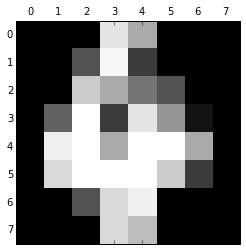

In [38]:
interact(check_net, rnge=True, check_number = [1,1796])